# MOFAFLEX on Mouse Brain SlideSeqV2 Data from NSF paper

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)

import plotting_settings
import seaborn as sns
from functools import partial
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import mofaflex as mfl
from plotnine import *
from data_loader import load_nsf_slideseq

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
data = load_nsf_slideseq()

In [3]:
model = mfl.MOFAFLEX.load("models/mofaflex.h5")

In [5]:
factors = model.get_factors()["group_1"]
covariates = pd.DataFrame(model.covariates["group_1"], columns=["x", "y"], index=factors.index)

df = pd.concat([factors, covariates], axis=1)
df_long = pd.melt(df, id_vars=["x", "y"], var_name="Factor", value_name="Score")

df_long["Factor"] = pd.Categorical(df_long["Factor"], categories=df_long["Factor"].unique(), ordered=True)

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 4 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/mofaflex_factor_scores.pdf


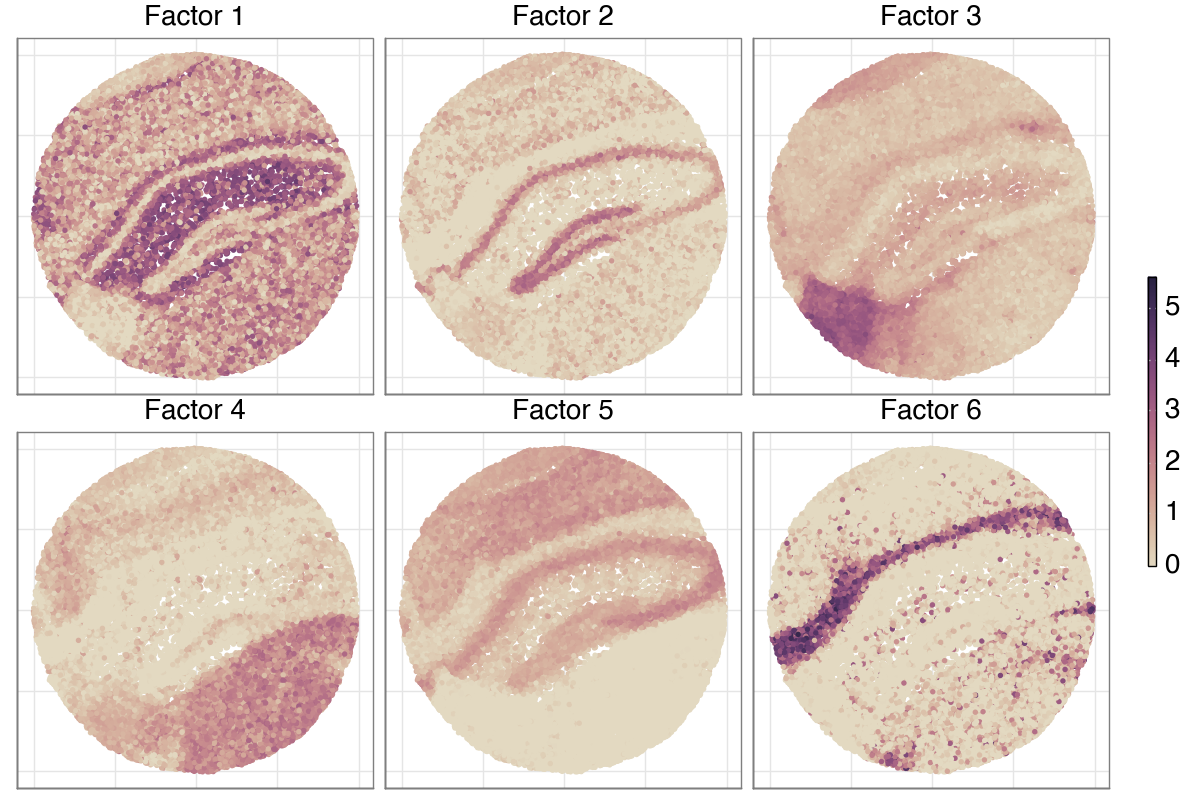

In [8]:
plot = (
    ggplot(df_long, aes(x="x", y="-y", color="Score"))
    + geom_point(size=0.1, raster=True)
    + theme(
        figure_size=(6, 4),
        axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_ticks_major_x=element_blank(),
        axis_ticks_major_y=element_blank(),
        legend_key_width=3.,
    )
    + labs(x="", y="", color="", title="")
    + coord_fixed(ratio=1)
    + scale_color_gradientn(colors=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)(np.linspace(0, 1, 256)))
    + facet_wrap("~Factor", ncol=3)
)

ggsave(plot, f"plots/mofaflex_factor_scores.pdf")
plot.show()

/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 8 x 5 in image.
/data/florin/micromamba/envs/mofaflex/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: plots/mofaflex_weights.pdf


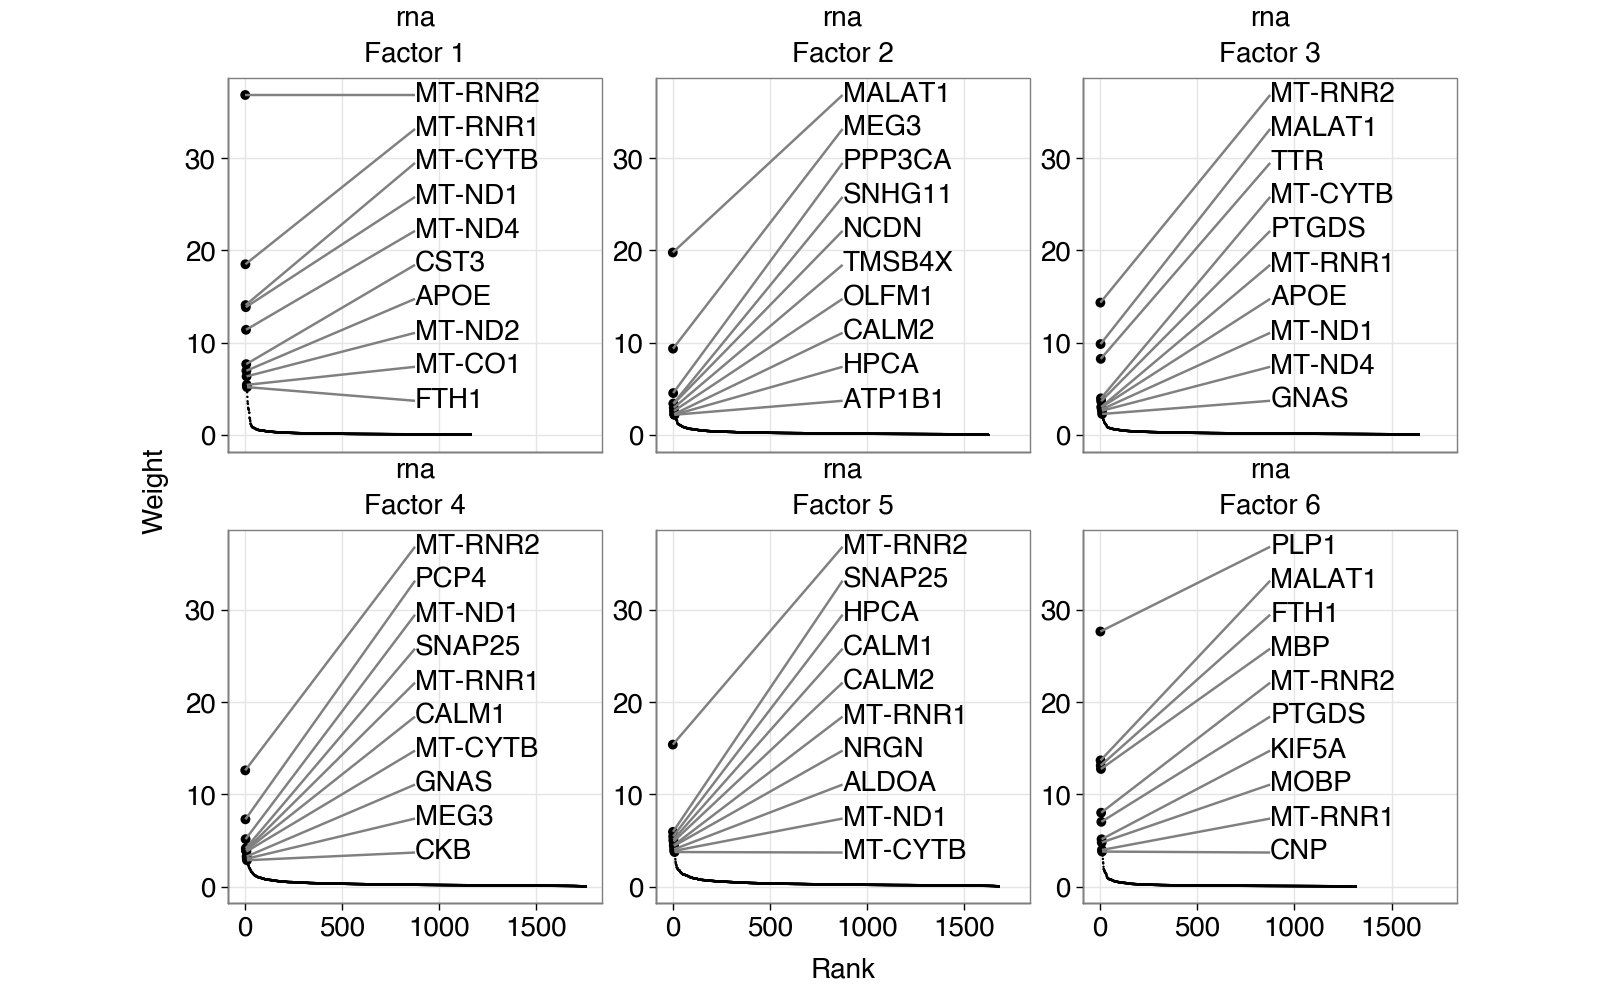

In [9]:
plot = mfl.pl.weights(model, ncol=3, figsize=(8, 5))
ggsave(plot, f"plots/mofaflex_weights.pdf")
plot.show()